## <b> Machine Learning </b> 


This assignment applies k-Nearest Neighbors regression to the Kaggle dataset titled 'Car Price Prediction' by Sukhmandeep Brar. 

The dataset includes various car features such as year of manufacturing, selling price, kilometers driven, fuel type, seller type, transmission type, number of previous owners, mileage, and engine specifications. Using these attributes, we have attempted to a create predictive models for estimating car selling prices.

https://www.kaggle.com/datasets/sukhmandeepsinghbrar/car-price-prediction-dataset

The general flow of this notebook is as follows: 
1. Data loading
2. Pre-preprocessing and Preliminary EDA
3. Initial Modelling using kNN Regressor (non-standardized, standardized, and reduced predictors)
4. Principal Component Analysis
5. Final Modelling aided by PCA 
6. Conclusion



<div class="alert alert-block alert-success">

<b>Summary of Results (n=3):</b>

1. Accuracy with non-standardized predictors: 46.98%%
2. Accuracy with standardized predictors: 81.4%
3. Accuracy using top three predictors: 87.15%
4. Accuracy using PCA: 81.29%

</div>

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [44]:
# load the dataset
df = pd.read_csv('cardekho.csv')

In [45]:
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage(km/ltr/kg),engine,max_power,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248.0,74,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497.0,78,5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396.0,90,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298.0,88.2,5.0


## <b> Pre-processing and Preliminary Exploratory Data Analysis </b>

<div class="alert alert-block alert-info">
This section removes duplications, views the counts of categorical data, and other basic info of the dataset.
</div>

In [46]:
df.shape, df.columns

((8128, 12),
 Index(['name', 'year', 'selling_price', 'km_driven', 'fuel', 'seller_type',
        'transmission', 'owner', 'mileage(km/ltr/kg)', 'engine', 'max_power',
        'seats'],
       dtype='object'))

In [47]:
#see duplicated rows
duplicate_df = df.duplicated()
duplicate_df.value_counts()

False    6926
True     1202
Name: count, dtype: int64

In [48]:
df.drop_duplicates(inplace=True)

In [49]:
df.columns

Index(['name', 'year', 'selling_price', 'km_driven', 'fuel', 'seller_type',
       'transmission', 'owner', 'mileage(km/ltr/kg)', 'engine', 'max_power',
       'seats'],
      dtype='object')

In [50]:
# mileage unit is in km/ltr/kg
df.rename(columns = {'mileage(km/ltr/kg)':'mileage'}, inplace=True)

In [51]:
#drop the rows with null values
df.dropna(inplace=True)

In [52]:
df.describe(include=['object'])

,name,fuel,seller_type,transmission,owner,max_power
count,6718,6718,6718,6718,6718,6718
unique,1983,4,3,2,5,319
top,Maruti Swift Dzire VDI,Diesel,Individual,Manual,First Owner,74
freq,118,3658,6025,6143,4176,324


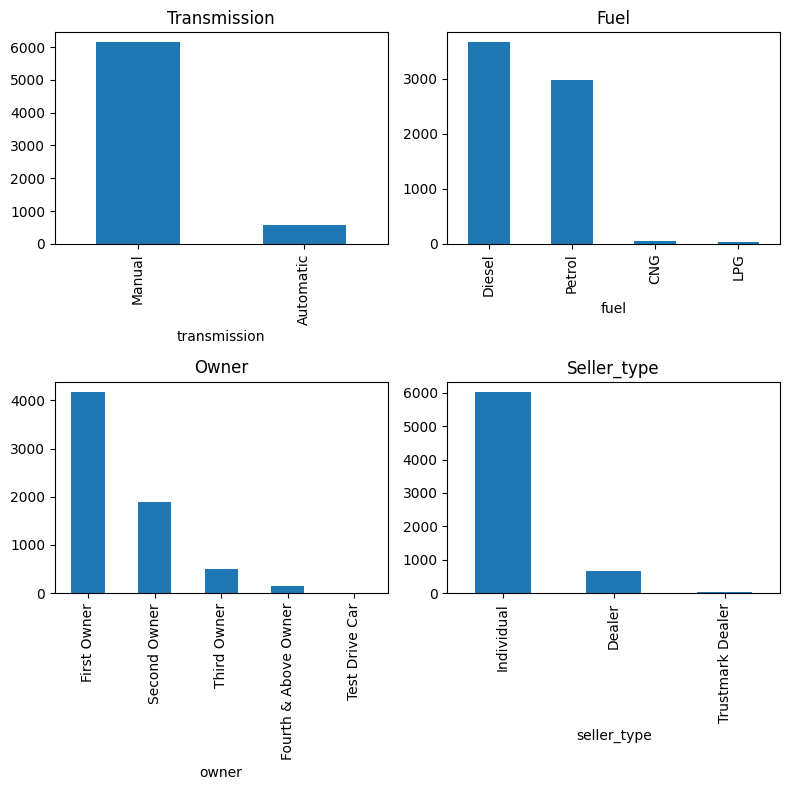

In [53]:
#frequency of each categorical data
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
cat_columns = ['transmission', 'fuel', 'owner', 'seller_type']

for i, col in enumerate(cat_columns):
    row = i // 2
    col_idx = i % 2
    df[col].value_counts().plot(kind='bar', ax=axes[row, col_idx])
    axes[row, col_idx].set_title(col.capitalize())
    axes[row, col_idx].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

#### Apply label encoding to ['transmission'] and ['owner']

In [54]:
transmission_mapping = {label:idx for idx,label in enumerate(np.unique(df['transmission']))}
df['transmission'] = df['transmission'].map(transmission_mapping)

In [55]:
owner_mapping = {
    'First Owner': 0,
    'Fourth & Above Owner': 1,
    'Second Owner': 2,
    'Third Owner': 3,
    'Test Drive Car': 4}
df['owner'] = df['owner'].map(owner_mapping)

#### Apply one-hot encoding to columns ['fuel'] and ['seller_type'].

In [56]:
df = pd.get_dummies(df, columns=['fuel'], drop_first=True, dtype=float) #reduce the features
df = pd.get_dummies(df, columns=['seller_type'], dtype=float)
df.drop(columns = 'seller_type_Trustmark Dealer', inplace=True)

In [57]:
#replace empty strings with np.nan and make all columns of float data type
df['max_power'] = df['max_power'].replace('', np.nan)
df['max_power'] = df['max_power'].replace(' ', np.nan)
df['max_power'] = df['max_power'].astype('float')

#fill missing value in max_power
df['max_power'].fillna(value=df['max_power'].mean(), inplace=True) 

/var/folders/3v/t7p60tvs5773q0xm_4_bb2tr0000gn/T/ipykernel_57455/3811983661.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['max_power'].fillna(value=df['max_power'].mean(), inplace=True)


In [58]:
df.rename(columns={'seller_type_Individual': 'seller_individual', 'seller_type_Dealer':'seller_Dealer'}, inplace=True)

In [59]:
df.head()

,name,year,selling_price,km_driven,transmission,owner,mileage,engine,max_power,seats,fuel_Diesel,fuel_LPG,fuel_Petrol,seller_Dealer,seller_individual
0,Maruti Swift Dzire VDI,2014,450000,145500,1,0,23.40,1248.0,74.00,5.0,1.0,0.0,0.0,0.0,1.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,1,2,21.14,1498.0,103.52,5.0,1.0,0.0,0.0,0.0,1.0
2,Honda City 2017-2020 EXi,2006,158000,140000,1,3,17.70,1497.0,78.00,5.0,0.0,0.0,1.0,0.0,1.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,1,0,23.00,1396.0,90.00,5.0,1.0,0.0,0.0,0.0,1.0
4,Maruti Swift VXI BSIII,2007,130000,120000,1,0,16.10,1298.0,88.20,5.0,0.0,0.0,1.0,0.0,1.0


<div class="alert alert-block alert-info">
This section explores the distribution and correlations of the predictors and the selling price. 
</div>

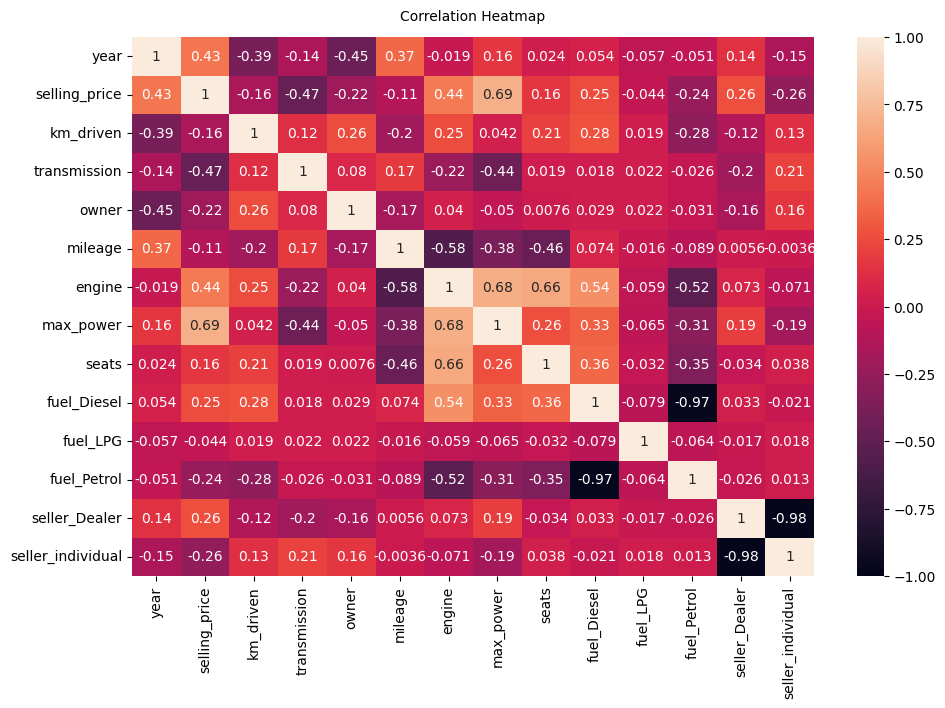

In [19]:
import seaborn as sns

plt.figure(figsize=(11, 7))
heatmap = sns.heatmap(df.corr(numeric_only=True), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':10}, pad=12);

<div class="alert alert-block alert-success">

<b>Observations:</b>

1. There is a moderate correlation between selling price and max power.
2. As anticipated, there is a strong negative correlation between fuel type Petrol and Diesel, as well as between seller type Dealer and Individual.
3. Effective predictors of selling price include year, max power, engine, and transmission (in no specific order).

</div>

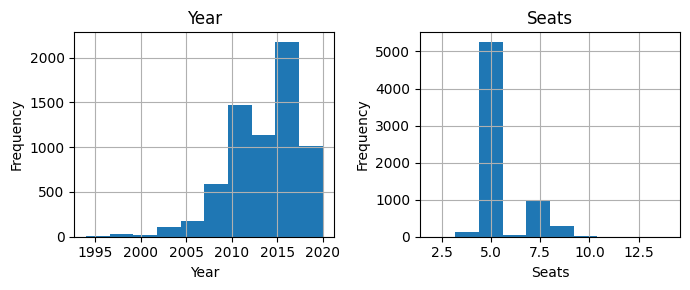

In [20]:
#plot the distribution of ordinal columns
numeric_col = ['year', #'selling_price', 'km_driven',
       #'mileage', 'engine', #'max_power', 
       'seats']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
axes = axes.flatten()

for i, col in enumerate(numeric_col):
    df[col].hist(ax=axes[i], bins=10)
    axes[i].set_title(col.capitalize())
    axes[i].set_xlabel(col.capitalize())
    axes[i].set_ylabel('Frequency')

# Hide the last subplot if the number of plots is odd
if len(numeric_col) % 2 != 0:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

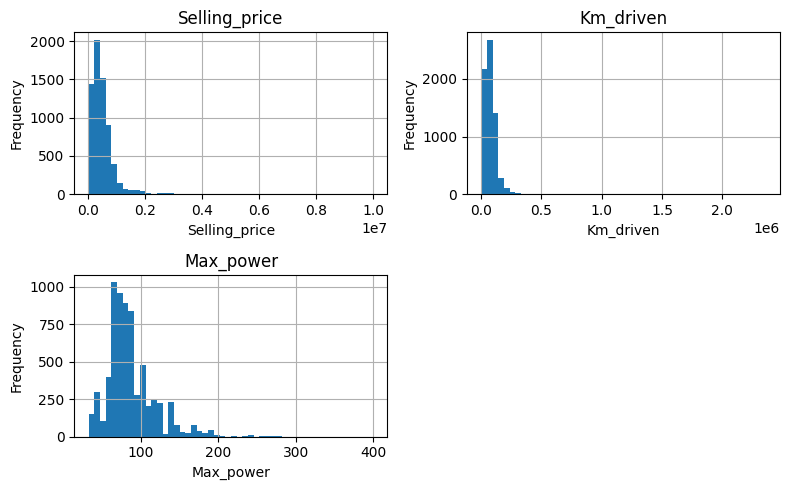

In [21]:
#plot the distribution of other numeric columns
numeric_col = [#'year', 
               'selling_price', 'km_driven',
       #'mileage', 'engine', 
       'max_power',] 
       #'seats']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 5))
axes = axes.flatten()

for i, col in enumerate(numeric_col):
    df[col].hist(ax=axes[i], bins=50)
    axes[i].set_title(col.capitalize())
    axes[i].set_xlabel(col.capitalize())
    axes[i].set_ylabel('Frequency')

if len(numeric_col) % 2 != 0:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-success">

Due to large difference in magnitudes and non-normal distributions of the numeric features, there is a need for standardization to get more accurate results. 

</div>

## <b> Initial Modelling <b>

<div class="alert alert-block alert-info">
This section performs kNN regression in different scales and set of predictors. <br>
1. Original scale of the predictors <br>
2. Standardized predictors <br>
3. Reduced predictors <br>
</div>

In [22]:
df.drop(columns='name', inplace=True)
y_data = df['selling_price'].values
x_data = df.drop(columns='selling_price')

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# split data to train and test sets
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

# trial KNN regression of n=5
reg = KNeighborsRegressor(n_neighbors=5)
reg.fit(X_train, y_train)

# predict the test set
y_pred = reg.predict(X_test)

In [24]:
#perform validation 
all_training = pd.DataFrame()
all_test = pd.DataFrame()
for seedN in range(1,100,1):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=seedN)
    training_accuracy = []
    test_accuracy = []
    neighbors_settings = range(1, 10) # try n_neighbors from 1 to 10
    for n_neighbors in neighbors_settings:
        reg = KNeighborsRegressor(n_neighbors=n_neighbors) # build the model
        reg.fit(X_train, y_train) 
        training_accuracy.append(reg.score(X_train, y_train)) # record training set accuracy
        test_accuracy.append(reg.score(X_test, y_test)) # record generalization accuracy
    all_training[seedN]=training_accuracy
    all_test[seedN] = test_accuracy

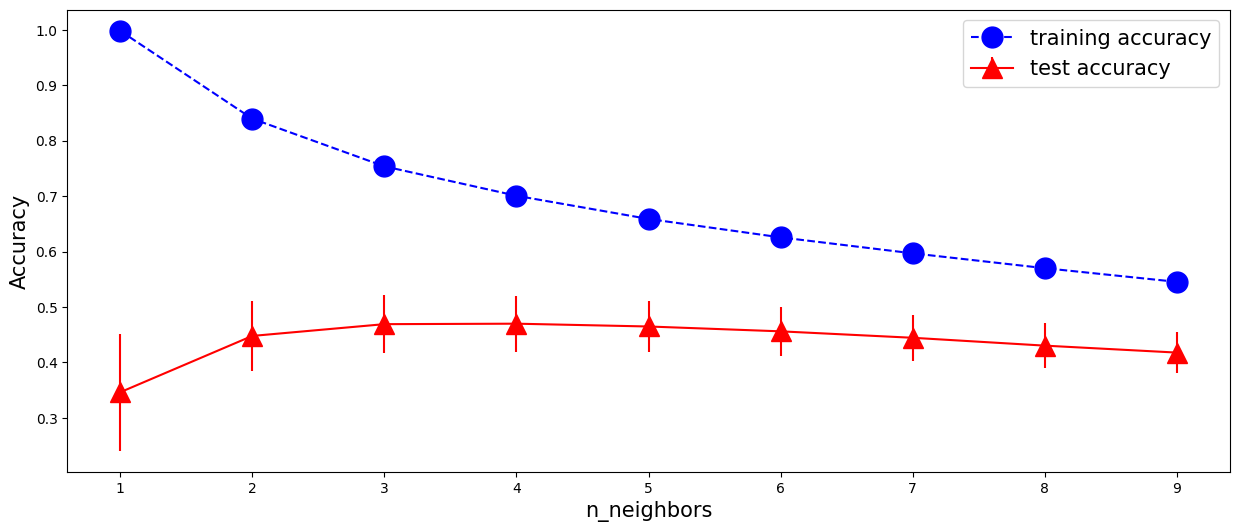

In [25]:
#plot the results of the validation 
fig = plt.figure(figsize=(15, 6))
import pylab as plot
params = {'legend.fontsize': 15, 'legend.handlelength': 2}
plot.rcParams.update(params)

plt.errorbar(neighbors_settings, all_training.mean(axis=1),
             yerr=all_training.std(axis=1), label="training accuracy", color='blue', marker='o', linestyle='dashed', markersize=15)
plt.errorbar(neighbors_settings, all_test.mean(axis=1),
             yerr=all_test.std(axis=1), label="test accuracy", color='red', marker='^', linestyle='-', markersize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.xlabel("n_neighbors",fontsize=15)
plt.legend()

In [26]:
all_test.iloc[3].mean()*100

46.975585255135265

<div class="alert alert-block alert-success">
Using the original scale of the predictors, the resulting accuracy is (n=3) 46.98% at best. 
</div>

### Standardizing the data

In [27]:
# standardize the data
x_data_std = (x_data - x_data.mean()) / x_data.std()
#x_data_limited = x_data_std[['transmission', 'max_power', 'year']]

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# split data to train and test sets
X_train, X_test, y_train, y_test = train_test_split(x_data_std, y_data, test_size=0.2, random_state=42)

# trial KNN regression of n=5
reg = KNeighborsRegressor(n_neighbors=5)
reg.fit(X_train, y_train)

# predict the test set
y_pred = reg.predict(X_test)

In [29]:
#perform validation 
all_training = pd.DataFrame()
all_test = pd.DataFrame()
for seedN in range(1,100,1):
    X_train, X_test, y_train, y_test = train_test_split(x_data_std, y_data, test_size=0.2, random_state=seedN)
    training_accuracy = []
    test_accuracy = []
    neighbors_settings = range(1, 10) # try n_neighbors from 1 to 10
    for n_neighbors in neighbors_settings:
        reg = KNeighborsRegressor(n_neighbors=n_neighbors) # build the model
        reg.fit(X_train, y_train) 
        training_accuracy.append(reg.score(X_train, y_train)) # record training set accuracy
        test_accuracy.append(reg.score(X_test, y_test)) # record generalization accuracy
    all_training[seedN]=training_accuracy
    all_test[seedN] = test_accuracy

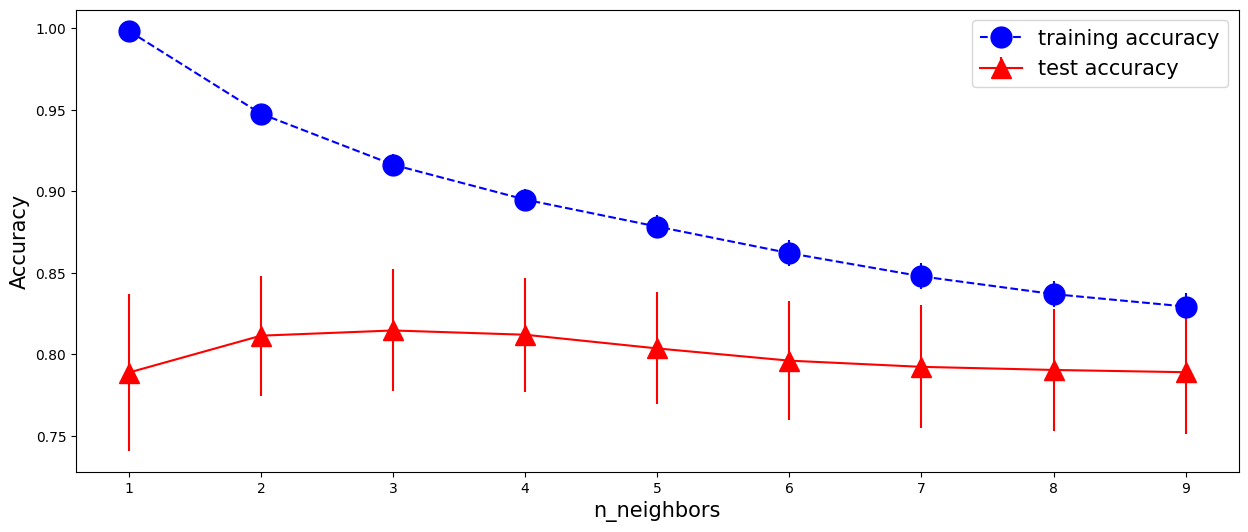

In [30]:
#plot the results of the validation 
fig = plt.figure(figsize=(15, 6))
import pylab as plot
params = {'legend.fontsize': 15, 'legend.handlelength': 2}
plot.rcParams.update(params)

plt.errorbar(neighbors_settings, all_training.mean(axis=1),
             yerr=all_training.std(axis=1), label="training accuracy", color='blue', marker='o', linestyle='dashed', markersize=15)
plt.errorbar(neighbors_settings, all_test.mean(axis=1),
             yerr=all_test.std(axis=1), label="test accuracy", color='red', marker='^', linestyle='-', markersize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.xlabel("n_neighbors",fontsize=15)
plt.legend()

In [31]:
all_test.iloc[3].mean()*100

81.20388472949365

<div class="alert alert-block alert-success">
Standardizing the predictors, best accuracy of 81.4% was achieved. This is a significant increase from the 46.97% (+34.43) from the results of the original scaling. However, this took a longer runtime from 43 seconds to around 210 seconds, a five-fold increase. There is also a larger variance. 
</div> 

### Reduced features

In [32]:
# standardize the data
x_data_std = (x_data - x_data.mean()) / x_data.std()
x_data_limited = x_data_std[['transmission', 'max_power', 'year']]

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# split data to train and test sets
X_train, X_test, y_train, y_test = train_test_split(x_data_limited, y_data, test_size=0.2, random_state=42)

# trial KNN regression of n=5
reg = KNeighborsRegressor(n_neighbors=5)
reg.fit(X_train, y_train)

# predict the test set
y_pred = reg.predict(X_test)

In [34]:
#perform validation 
all_training = pd.DataFrame()
all_test = pd.DataFrame()
for seedN in range(1,100,1):
    X_train, X_test, y_train, y_test = train_test_split(x_data_limited, y_data, test_size=0.2, random_state=seedN)
    training_accuracy = []
    test_accuracy = []
    neighbors_settings = range(1, 10) # try n_neighbors from 1 to 10
    for n_neighbors in neighbors_settings:
        reg = KNeighborsRegressor(n_neighbors=n_neighbors) # build the model
        reg.fit(X_train, y_train) 
        training_accuracy.append(reg.score(X_train, y_train)) # record training set accuracy
        test_accuracy.append(reg.score(X_test, y_test)) # record generalization accuracy
    all_training[seedN]=training_accuracy
    all_test[seedN] = test_accuracy

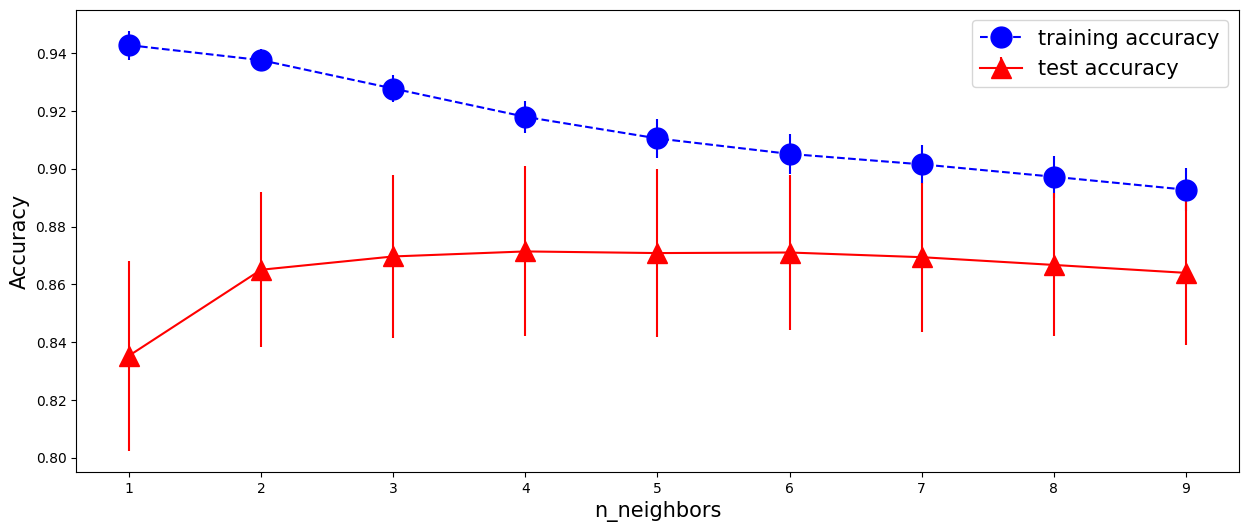

In [35]:
#plot the results of the validation 
fig = plt.figure(figsize=(15, 6))
import pylab as plot
params = {'legend.fontsize': 15, 'legend.handlelength': 2}
plot.rcParams.update(params)

plt.errorbar(neighbors_settings, all_training.mean(axis=1),
             yerr=all_training.std(axis=1), label="training accuracy", color='blue', marker='o', linestyle='dashed', markersize=15)
plt.errorbar(neighbors_settings, all_test.mean(axis=1),
             yerr=all_test.std(axis=1), label="test accuracy", color='red', marker='^', linestyle='-', markersize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.xlabel("n_neighbors",fontsize=15)
plt.legend()

In [36]:
all_test.iloc[3].mean()*100

87.13724940195077

<div class="alert alert-block alert-success">
Selecting only ['transmission', 'max_power', 'year'] as predictors results to an accuracy of 87.15% (n=3), a more accurate model than the standardized features. The variance of both cases are similar. 
</div>

## <b> Principal Component Analysis </b>

<div class="alert alert-block alert-info">
Peforming PCA in the dataset attempts to capture the axes of maximal variance of the predictors to result to a higher accruacy. The multicollinearity between Seller_dealer and seller_individual and fuel_Petrol and fuel_Diesel will also be resolved.  
</div>

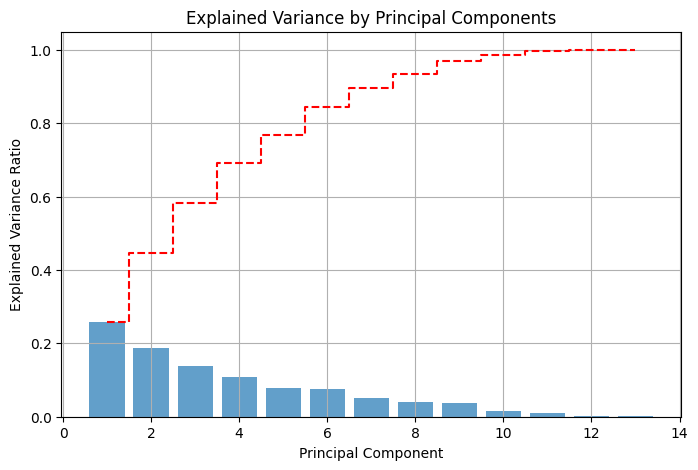

In [37]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(x_data)

pca = PCA()
df_scaled = pca.fit(scaled_data)

# Get explained variance
explained_variance = pca.explained_variance_ratio_

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, align='center')
plt.step(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), where='mid', linestyle='--', color='red')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.grid(True)
plt.show()

In [38]:
np.cumsum(explained_variance)

array([0.25748661, 0.44539845, 0.58256148, 0.69211512, 0.76923657,
       0.84368186, 0.89556372, 0.9347084 , 0.97092697, 0.98733767,
       0.99716511, 0.99883409, 1.        ])

<div class="alert alert-block alert-success">
We reduce the 13 features to 6 principal components as these PCs reach a cumulative variance of 84.4%. 
</div>

In [39]:
# retain the first 6 PCs
pca = PCA(n_components=6)
#X_new, eigenvectors, variance_explained = pca(scaled_data)
scaled_data_pca = pca.fit_transform(scaled_data)


Principal Component Loadings:
 [[-3.98876185e-02 -5.65358347e-01 -4.58365087e-01 -4.61564778e-01
   3.54714009e-02 -9.31266621e-02]
 [ 3.76293273e-01  4.80381807e-01  5.95321198e-02  4.00492143e-01
  -5.49905661e-02  2.93909520e-02]
 [-2.32684631e-01  4.32144283e-01 -3.25396279e-01  2.94941942e-01
  -1.18521100e-01 -5.89183133e-01]
 [ 7.86840994e-02  5.00856786e-01  2.92252954e-01  3.82967934e-01
  -7.08706505e-02  3.67505587e-01]
 [-4.78781681e-01 -1.83799813e-01 -7.39623738e-01  1.59310322e-01
  -2.90910589e-02  2.13668119e-01]
 [ 9.16491797e-01  5.45737106e-03  1.53888124e-01 -1.75965631e-01
   6.60199541e-04 -8.43701254e-02]
 [ 6.90694413e-01 -3.08537312e-01  1.99861148e-01 -2.78514403e-01
   4.00991631e-02  2.89993360e-01]
 [ 6.79410546e-01  1.48609129e-01  7.09517266e-02 -1.93593161e-01
  -2.30260857e-02 -5.21973868e-01]
 [ 7.47919547e-01  6.57725522e-02 -5.83764128e-01  1.85645282e-01
  -4.55801532e-02  1.28864149e-01]
 [-5.26636024e-02  7.49360817e-02  2.00354635e-02  1.457637

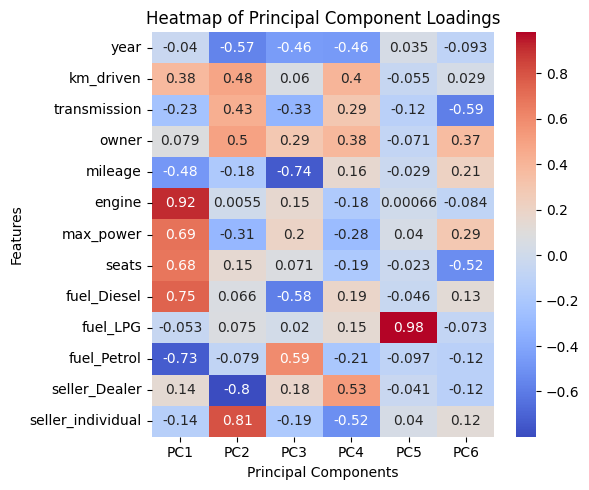

In [40]:
# PC loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
print("\nPrincipal Component Loadings:\n", loadings)
principal_components = [f'PC{i+1}' for i in range(loadings.shape[1])]

# Plot the heatmap of the loadings
plt.figure(figsize=(6, 5))  # Increase the size of the plot
sns.heatmap(loadings, annot=True, cmap='coolwarm', xticklabels=principal_components, yticklabels=x_data.columns, annot_kws={"size": 10})
plt.title('Heatmap of Principal Component Loadings')
plt.xlabel('Principal Components')
plt.ylabel('Features')
plt.tight_layout()  
plt.show()

## <b> PCA-aided kNN Regression </b>

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# split data to train and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_data_pca, y_data, test_size=0.2, random_state=42)

# trial KNN regression
reg = KNeighborsRegressor(n_neighbors=5)
reg.fit(X_train, y_train)

# predict the test set
y_pred = reg.predict(X_test)

In [42]:
all_training = pd.DataFrame()
all_test = pd.DataFrame()
for seedN in range(1,100,1):
    X_train, X_test, y_train, y_test = train_test_split(scaled_data_pca, y_data, test_size=0.2, random_state=seedN)
    training_accuracy = []
    test_accuracy = []
    neighbors_settings = range(1, 10) # try n_neighbors from 1 to 10
    for n_neighbors in neighbors_settings:
        reg = KNeighborsRegressor(n_neighbors=n_neighbors) # build the model
        reg.fit(X_train, y_train) 
        training_accuracy.append(reg.score(X_train, y_train)) # record training set accuracy
        test_accuracy.append(reg.score(X_test, y_test)) # record generalization accuracy
    all_training[seedN]=training_accuracy
    all_test[seedN] = test_accuracy

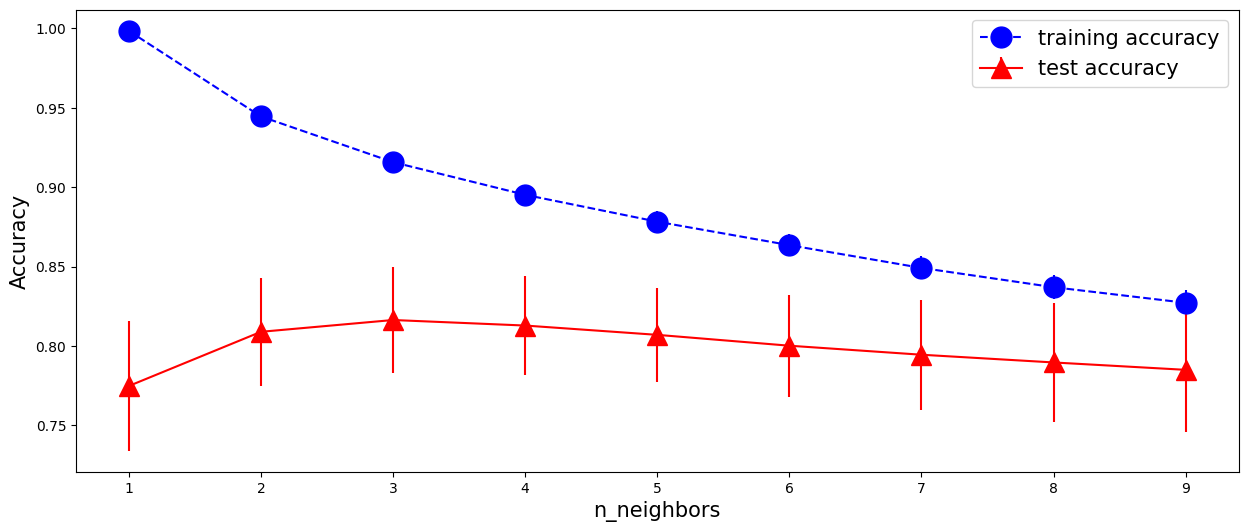

In [45]:
fig = plt.figure(figsize=(15, 6))
import pylab as plot
params = {'legend.fontsize': 15, 'legend.handlelength': 2}
plot.rcParams.update(params)

plt.errorbar(neighbors_settings, all_training.mean(axis=1),
             yerr=all_training.std(axis=1), label="training accuracy", color='blue', marker='o', linestyle='dashed', markersize=15)
plt.errorbar(neighbors_settings, all_test.mean(axis=1),
             yerr=all_test.std(axis=1), label="test accuracy", color='red', marker='^', linestyle='-', markersize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.xlabel("n_neighbors",fontsize=15)
plt.legend()

In [46]:
all_test.iloc[3].mean()*100

81.28981572886036

<div class="alert alert-block alert-success">
The performance of the model using 6 principal components is comparable to standardizing features in terms of accuracy (81.29%). The runtime was however reduced to 44 seconds (5x faster).
</div>

## <b>Conclusions</b>

1. Normalization can significantly improve performance.
2. Correlation matrix is an effective way for feature selection.
3. A smaller set of features improve runtime performance.
4. PCA is a good representation of data for dimensionality reduction.
